In [1]:
import pandas as pd
import xgboost as xgb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from hyperopt import hp, tpe, Trials, STATUS_OK, fmin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from rdkit import DataStructs, Chem
from rdkit.Chem import AllChem
import shap
import category_encoders as ce
from BorutaShap import BorutaShap
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_validate
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,AdaBoostRegressor,BaggingRegressor,ExtraTreesRegressor,GradientBoostingRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge,ARDRegression,BayesianRidge,ElasticNet,GammaRegressor,HuberRegressor
from sklearn.linear_model import Lasso, LassoLars, LinearRegression, LogisticRegression, PassiveAggressiveRegressor,Ridge,SGDRegressor

In [2]:
train_ClO2 = pd.read_csv('ClO2/ClO2_train_data.csv')
test_ClO2 = pd.read_csv('ClO2/ClO2_test.csv')
train_ClO2 = train_ClO2[['compounds', 'new_smile', 'pH', 'logk']]
test_ClO2 = test_ClO2[['compounds', 'new_smile', 'pH', 'logk']]

train_O3 = pd.read_csv('O3/O3_train_data.csv')
test_O3 = pd.read_csv('O3/O3_test.csv')
train_O3 = train_O3[['Compound', 'new_smile', 'pH', 'logk']]
test_O3 = test_O3[['Compound', 'new_smile', 'pH', 'logk']]

train_HClO = pd.read_csv('HClO/HClO_train_data.csv')
test_HClO = pd.read_csv('HClO/HClO_test.csv')
train_HClO = train_HClO[['compoud', 'new_smile', 'pH', 'logk']]
test_HClO = test_HClO[['compoud', 'new_smile', 'pH', 'logk']]

train_SO4 = pd.read_csv('SO4/SO4_train_data.csv')
test_SO4 = pd.read_csv('SO4/SO4_test.csv')

train_SO4 = train_SO4[['chemical compound', 'new_smile', 'pH',  'logK','T ']]
test_SO4 = test_SO4[['chemical compound', 'new_smile', 'pH', 'logK', 'T ']]

train_2 = pd.read_csv('OH/train_1.csv')
train_1 = pd.read_csv('OH/val_1.csv')
test_OH = pd.read_csv('OH/test_1.csv')
train_OH = pd.concat([train_1, train_2], ignore_index=True)
train_OH.head()

,Compound,SMILES,Unnamed: 2,chemical class,LogKOH
0,"3,6-Diaminoacridine (Proflavine)",Nc1ccc2cc3ccc(N)cc3nc2c1,NaN,pyridine,10.000
1,(4-Chloro-2-methylphenoxy)acetic acid,Cc1cc(Cl)ccc1OCC(=O)O,NaN,benzene-carboxyl-ether-X,9.398
2,Methylcyclopentane,CC1CCCC1,NaN,cyclo,9.845
3,Orotidine monophosphate,O=C(O)c1cc(=O)[nH]c(=O)n1[C@@H]1O[C@H](COP(=O)...,NaN,cyclo-OH,9.681
4,Propachlor,CC(C)N(C(=O)CCl)c1ccccc1,NaN,amide-benzene,9.660


In [3]:
train_ClO2['T ']=25
test_ClO2['T ']=25
train_O3['T ']=25
test_O3['T ']=25
train_HClO['T ']=25
test_HClO['T ']=25
train_OH['T ']=25
test_OH['T ']=25
train_OH['pH']=7
test_OH['pH']=7

In [4]:
train_ClO2['oxidant']='ClO2'
test_ClO2['oxidant']='ClO2'
train_O3['oxidant']='O3'
test_O3['oxidant']='O3'
train_HClO['oxidant']='HClO'
test_HClO['oxidant']='HClO'
train_SO4['oxidant']='SO4'
test_SO4['oxidant']='SO4'
train_OH['oxidant']='OH'
test_OH['oxidant']='OH'

In [5]:
train_OH=train_OH[['Compound', 'SMILES',  'pH', 'LogKOH', 'T ','oxidant']]
test_OH=test_OH[['Compound', 'SMILES',  'pH', 'LogKOH', 'T ','oxidant']]

In [6]:
train_ClO2.columns=train_SO4.columns
test_ClO2.columns=train_SO4.columns
train_O3.columns=train_SO4.columns
test_O3.columns=train_SO4.columns
train_HClO.columns=train_SO4.columns
test_HClO.columns=train_SO4.columns
train_OH.columns=train_SO4.columns
test_OH.columns=train_SO4.columns

In [7]:
len(train_ClO2), len(train_HClO), len(train_O3), len(train_SO4), len(train_OH)

(152, 156, 607, 445, 980)

In [8]:
len(test_ClO2),len(test_HClO), len(test_O3), len(test_SO4), len(test_OH)

(39, 39, 152, 112, 109)

In [9]:
train_data = pd.concat([train_ClO2, train_O3, train_HClO, train_SO4, train_OH], ignore_index=True)
train_data.head()

,chemical compound,new_smile,pH,logK,T,oxidant
0,3-methoxyphenolate,COc1cccc([O-])c1,NaN,7.690196,25.0,ClO2
1,4-Styrenesulfonic Acid,C=Cc1ccc(S(=O)(=O)O)cc1,NaN,-1.886057,25.0,ClO2
2,2-carboxylatophenol,O=C([O-])c1ccccc1O,NaN,5.739687,25.0,ClO2
3,"N,N-dimethyl-4-Cl-benzylamine",CN(C)Cc1ccc(Cl)cc1,NaN,4.301030,25.0,ClO2
4,Lomefloxacin,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c21,6.31,0.146128,25.0,ClO2


In [10]:
len(train_data)

2340

In [11]:
test_data = pd.concat([test_ClO2, test_O3, test_HClO, test_SO4,test_OH], ignore_index=True)
test_data.head()

,chemical compound,new_smile,pH,logK,T,oxidant
0,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,7.0,6.100371,25.0,ClO2
1,"N,N-dimethyl-4-methoxybenzylamine",COc1ccc(CN(C)C)cc1,NaN,4.690196,25.0,ClO2
2,pentachlorophenolate,[O-]c1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,NaN,3.146128,25.0,ClO2
3,4-acetylphenolate,CC(=O)c1ccc([O-])cc1,NaN,5.903090,25.0,ClO2
4,tryptophan,N[C@@H](Cc1c[nH]c2ccccc12)C(=O)O,7.0,4.531479,25.0,ClO2


In [12]:
len(test_data)

451

In [13]:
data = pd.concat([train_data, test_data])
len(data)

2791

In [14]:
ClO2=data[data['oxidant']=='ClO2']
O3=data[data['oxidant']=='O3']
SO4=data[data['oxidant']=='SO4']
HClO=data[data['oxidant']=='HClO']
OH = data[data['oxidant']=='OH']

In [15]:
ClO2.to_excel('all/clo2.xlsx', index=False)
O3.to_excel('all/o3.xlsx', index=False)
HClO.to_excel('all/Hclo.xlsx', index=False)
SO4.to_excel('all/SO4.xlsx', index=False)
OH.to_excel('all/OH.xlsx', index=False)

In [16]:
class morgan_fp:
    def __init__(self, radius, length):
        self.radius = radius
        self.length = length
    def __call__(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, self.length)
        npfp = np.array(list(fp.ToBitString())).astype('float32')
        return npfp

In [17]:
train_data.columns

Index(['chemical compound', 'new_smile', 'pH', 'logK', 'T ', 'oxidant'], dtype='object')

In [18]:
categorical_features = ['oxidant']

In [19]:
def conv_data(data,data_t,fp, en):
    data['pH'].fillna(value=7, inplace=True)
    data['T '].fillna(value=25, inplace=True)
    data['fp'] = data['new_smile'].apply(fp)
    x_fp=np.array(list(data['fp']))
    
    X_train = data_t.drop(columns=['chemical compound', 'new_smile', 'logK','fp']).copy()
    Y_train = data_t['logK'].copy()
    en.fit(X_train, Y_train)
    
    x = data.drop(columns=['chemical compound', 'new_smile', 'logK', 'fp']).copy()
    y = data['logK'].copy()
    xx = en.transform(x, y) ##cat_pd
    
    col= [str(i) for i in range(x_fp.shape[1])]
    
    fp_pd = pd.DataFrame(data = x_fp, columns=col)
   
    y = data['logK'].values
    hh = pd.concat([fp_pd, xx], axis =1)
    return hh, y

In [20]:
##remove outlier 
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

In [21]:
fp = morgan_fp(1,2048)
en = ce.james_stein.JamesSteinEncoder(cols = categorical_features)
x_train_pd, y_train = conv_data(train_data, train_data,fp, en)
x_train_pd['logk']=y_train
x_train = x_train_pd.values
x_test_pd, y_test = conv_data(test_data, train_data,fp, en)
x_test_pd['logk']=y_test
x_test = x_test_pd.values

In [22]:
model = [KNN(), ABOD(), IForest(random_state=20), CBLOF(random_state=20), FeatureBagging(random_state=20), 
         HBOS(), LOF(), KNN(n_neighbors=10), KNN(method='mean'), KNN(p=3)]
train_scores = np.zeros([x_train.shape[0], len(model)])
test_scores = np.zeros([x_test.shape[0], len(model)])
for i in range(len(model)):
    clf = model[i]
    clf.fit(x_train)
    train_scores[:, i]= clf.decision_scores_
    test_scores[:, i]= clf.decision_function(x_test) 
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

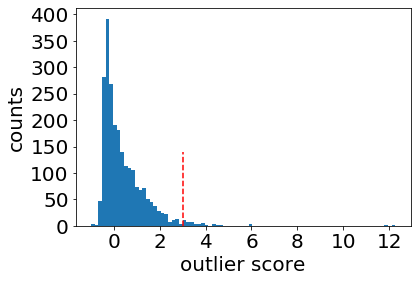

In [23]:
#y_by_moa = maximization(test_scores_norm)
y_by_moa_train = moa(train_scores_norm, n_buckets=5)
plt.hist(y_by_moa_train, bins='auto')
plt.xlabel('outlier score', fontsize =20)
plt.ylabel('counts', fontsize =20)
plt.xticks(fontsize=20)
plt.yticks(fontsize =20)
plt.vlines(x=3, ymin=0, ymax = 140,linestyles='--', colors='r' )
plt.savefig('all/train_outlier.png', bbox_inches = 'tight')
plt.show()

In [24]:
df_test = pd.DataFrame(x_train)
df_test['y_by_moa_score'] = y_by_moa_train
df_test['y_by_moa_cluster'] = np.where(df_test['y_by_moa_score']<3.0, 0, 1)
df_test['y_by_moa_cluster'].value_counts()

0    2288
1      52
Name: y_by_moa_cluster, dtype: int64

In [25]:
df_test[df_test['y_by_moa_cluster']==1]

,0,1,2,3,4,5,6,7,8,9,...,2044,2045,2046,2047,2048,2049,2050,2051,y_by_moa_score,y_by_moa_cluster
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,25.00,4.302412,2.653213,3.131430,1
63,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,25.00,4.302412,0.000000,4.387490,1
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,25.00,4.302412,3.176091,3.030928,1
115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,25.00,4.302412,-0.075721,3.091894,1
127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,25.00,4.302412,4.146128,3.595921,1
158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,25.00,4.203640,6.431364,3.451257,1
237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,25.00,4.203640,6.778151,3.224338,1
258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,25.00,4.203640,2.443245,3.904737,1
262,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,25.00,4.203640,5.880000,3.013717,1
311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.1,25.00,4.203640,5.403121,3.224544,1


In [26]:
train_data.drop(index = df_test[df_test['y_by_moa_cluster']==1].index, inplace=True)
train_data.reset_index(drop=True, inplace=True)

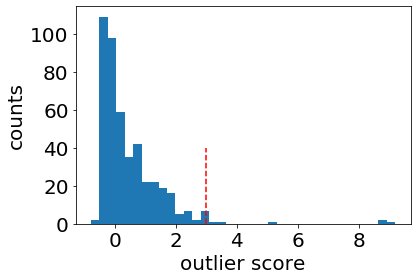

In [27]:
y_by_moa_test = moa(test_scores_norm, n_buckets=5)
plt.hist(y_by_moa_test, bins='auto')
plt.xlabel('outlier score', fontsize =20)
plt.ylabel('counts', fontsize =20)
plt.xticks(fontsize=20)
plt.yticks(fontsize =20)
plt.vlines(x=3, ymin=0, ymax = 40,linestyles='--', colors='r' )
plt.savefig('all/test_outlier.png', bbox_inches = 'tight')
plt.show()

In [28]:
df_test = pd.DataFrame(x_test)
df_test['y_by_moa_score'] = y_by_moa_test
df_test['y_by_moa_cluster'] = np.where(df_test['y_by_moa_score']<3, 0, 1)
df_test['y_by_moa_cluster'].value_counts()

0    444
1      7
Name: y_by_moa_cluster, dtype: int64

In [29]:
df_test[df_test['y_by_moa_cluster']==1]

,0,1,2,3,4,5,6,7,8,9,...,2044,2045,2046,2047,2048,2049,2050,2051,y_by_moa_score,y_by_moa_cluster
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.00,25.00,4.302412,3.244275,3.089161,1
137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.00,25.00,4.203640,5.579784,3.600725,1
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.88,25.00,4.203640,4.274158,3.245708,1
241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.50,9.40,8.477577,7.496930,8.849091,1
248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.50,9.10,8.477577,7.374748,9.186918,1
307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.00,31.85,8.477577,5.959041,5.247292,1
333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.50,9.50,8.477577,7.858537,8.775708,1


In [30]:
test_data.drop(index = df_test[df_test['y_by_moa_cluster']==1].index, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [31]:
x_train_pd, y_train = conv_data(train_data,train_data, fp, en)
x_train= x_train_pd.values

In [32]:
train_data.to_excel('all/train_data_5.xlsx', index=False)
test_data.to_excel('all/test_data_5.xlsx', index=False)

In [33]:
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=10)

In [36]:
models = [CatBoostRegressor(verbose =False, random_state=10),XGBRegressor(random_state=10), svm.SVR(),
          RandomForestRegressor(random_state=10),AdaBoostRegressor(random_state=10),
         BaggingRegressor(random_state=10),ExtraTreesRegressor(random_state=10),
          GradientBoostingRegressor(random_state=10),DecisionTreeRegressor(random_state=10),
         Lasso(random_state=10), LassoLars(random_state=10), LinearRegression(),
          PassiveAggressiveRegressor(random_state=10),Ridge(random_state=10),SGDRegressor(random_state=10) ]
encoder = [ce.backward_difference.BackwardDifferenceEncoder(cols = categorical_features), 
               ce.basen.BaseNEncoder(cols = categorical_features),
               ce.binary.BinaryEncoder(cols = categorical_features), 
                ce.helmert.HelmertEncoder(cols = categorical_features),
                ce.james_stein.JamesSteinEncoder(cols = categorical_features),
                ce.one_hot.OneHotEncoder(cols = categorical_features),
                ce.m_estimate.MEstimateEncoder(cols = categorical_features),
                ce.sum_coding.SumEncoder(cols = categorical_features)]
results = pd.DataFrame(columns=['train_rmse','train_r2', 'test_rmse','test_r2', 'name', 'encoder'])


k =0 
for model in models:
    for en in encoder:
        t_rmse=[]
        t_r2=[]
        v_rmse=[]
        v_r2=[]
        for train_index, test_index in kf.split(train_data):
            train = train_data.loc[train_index]
            train.reset_index(drop=True, inplace=True)
            val = train_data.loc[test_index]
            val.reset_index(drop=True, inplace=True)
            x_train_pd, y_train = conv_data(train, train, fp, en)
            x_train = x_train_pd.values
            x_val_pd, y_val = conv_data(val, train, fp, en)
            x_val = x_val_pd.values
            model.fit(x_train, y_train)
            t_rmse.append(np.sqrt(mean_squared_error(y_train, model.predict(x_train))))
            t_r2.append(r2_score(y_train, model.predict(x_train)))
            v_rmse.append(np.sqrt(mean_squared_error(y_val, model.predict(x_val))))
            v_r2.append(r2_score(y_val, model.predict(x_val)))
        results.loc[k, 'train_rmse']=np.mean(t_rmse)
        results.loc[k, 'test_rmse']=np.mean(v_rmse)
        results.loc[k, 'train_r2']=np.mean(t_r2)
        results.loc[k, 'test_r2']=np.mean(v_r2)
        results.loc[k, 'name']=model.__class__.__name__
        results.loc[k, 'encoder']=en.__class__.__name__
        #results.loc[k, 'scaler']=sc.__class__.__name__
        k+=1

In [37]:
results.sort_values(['test_rmse'], ascending= True, inplace = True)
results.head(10)

,train_rmse,train_r2,test_rmse,test_r2,name,encoder
31,0.502330,0.977252,1.275627,0.852290,RandomForestRegressor,SumEncoder
29,0.502727,0.977217,1.276782,0.852027,RandomForestRegressor,OneHotEncoder
3,0.831505,0.937715,1.289591,0.849215,CatBoostRegressor,HelmertEncoder
11,0.644335,0.962605,1.290831,0.848711,XGBRegressor,HelmertEncoder
5,0.837962,0.936745,1.296751,0.847520,CatBoostRegressor,OneHotEncoder
7,0.838613,0.936644,1.297549,0.847365,CatBoostRegressor,SumEncoder
13,0.651945,0.961656,1.299065,0.847107,XGBRegressor,OneHotEncoder
8,0.660482,0.960692,1.301193,0.846131,XGBRegressor,BackwardDifferenceEncoder
15,0.651945,0.961656,1.305000,0.845663,XGBRegressor,SumEncoder
14,0.663763,0.960277,1.305805,0.845091,XGBRegressor,MEstimateEncoder


In [38]:
results.to_excel('all/all_model_selection_5.xlsx', index=False)

In [39]:
space = {'n_estimators': hp.quniform('n_estimators', 1,100,1),
         'min_samples_split': hp.uniform('min_samples_split', 0, 1),
         'max_features': hp.uniform('max_features', 0, 1),
          'fp_radius':hp.randint('fp_radius', 5),
        'fp_length': hp.quniform('fp_length', 10, 2048, 1)}

In [43]:
import pickle
en=ce.sum_coding.SumEncoder(cols = categorical_features)
def fit(params):
    fp = morgan_fp(params['fp_radius'], params['fp_length'])
    model = RandomForestRegressor(n_estimators=params['n_estimators'], min_samples_split=params['min_samples_split'],
                                  max_features=params['max_features'], random_state=10)
    
    t_rmse=[]
    v_rmse=[]
    for train_index, test_index in kf.split(train_data):
        train = train_data.loc[train_index]
        train.reset_index(drop=True, inplace=True)
        val = train_data.loc[test_index]
        val.reset_index(drop=True, inplace=True)
        x_train_pd, y_train = conv_data(train, train, fp, en)
        x_train = x_train_pd.values
        x_val_pd, y_val = conv_data(val, train, fp, en)
        x_val = x_val_pd.values
        model.fit(x_train, y_train)
        t_rmse.append(np.sqrt(mean_squared_error(y_train, model.predict(x_train))))
        v_rmse.append(np.sqrt(mean_squared_error(y_val, model.predict(x_val))))
    
    return np.mean(v_rmse), np.mean(t_rmse)

def objective(params):
    global ITERATION
    ITERATION +=1
    for name in ['n_estimators','fp_radius', 'fp_length']:
        params[name] = int(params[name])
    loss, train_loss = fit(params)
    loss =loss
    off_connection = open(out_file, 'a')
    writer = csv.writer(off_connection)
    writer.writerow([loss,train_loss, params, ITERATION])
    #pickle.dump(bayes_trial, open("per_2_xgb.p", "wb"))
    return {'loss':loss,'train_loss':train_loss, 'params': params, 'iteration':ITERATION, 'status':STATUS_OK}



In [44]:
import csv
out_file ='unified_5.csv'
off_connection =open(out_file, 'w')
writer = csv.writer(off_connection)
writer.writerow(['loss','train_loss', 'params', 'iteration'])
off_connection.close()

tpe_algo = tpe.suggest
bayes_trial = Trials()

In [45]:
##%%capture
global ITERATION
ITERATION =0
best = fmin(fn = objective, space =space, algo = tpe_algo, trials = bayes_trial, max_evals=3000, rstate= np.random.RandomState(50)) 

100%|████████████████████████████████████████████| 3000/3000 [10:21:27<00:00, 12.43s/it, best loss: 1.2315687800589525]


In [34]:
result = pd.read_csv('unified_5.csv')
result.sort_values('loss', ascending= True, inplace = True)
result.reset_index(drop = True, inplace =True)
result.head(5)

,loss,train_loss,params,iteration
0,1.231569,0.532344,"{'fp_length': 846, 'fp_radius': 1, 'max_featur...",1071
1,1.231839,0.492603,"{'fp_length': 846, 'fp_radius': 1, 'max_featur...",1491
2,1.232525,0.492120,"{'fp_length': 900, 'fp_radius': 1, 'max_featur...",2954
3,1.234540,0.493988,"{'fp_length': 820, 'fp_radius': 1, 'max_featur...",1615
4,1.235177,0.532870,"{'fp_length': 820, 'fp_radius': 1, 'max_featur...",1150


In [35]:
for i in range(3000):
    if result['loss'][i]>1.275627:
        print(i)
        break

369


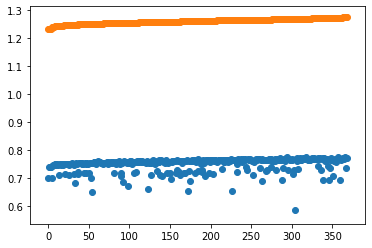

In [36]:
hh = range(i)
xx = result['loss'][:i]-result['train_loss'][:i]
plt.scatter(hh, xx)
plt.scatter(hh, result['loss'][:i])

In [37]:
np.min(xx), list(xx).index(np.min(xx))

(0.586009383167193, 304)

In [38]:
result['loss'][304],result['train_loss'][304]

(1.2692334489025623, 0.6832240657353693)

In [39]:
import ast
params = ast.literal_eval(result['params'][304])
params

{'fp_length': 1022,
 'fp_radius': 1,
 'max_features': 0.34578314203801014,
 'min_samples_split': 0.0043270348905830825,
 'n_estimators': 86}

In [40]:
train_data=pd.read_excel('all/train_data_5.xlsx')
test_data=pd.read_excel('all/test_data_5.xlsx')

In [41]:
fp = morgan_fp(params['fp_radius'], params['fp_length'])
model = RandomForestRegressor(n_estimators=params['n_estimators'], min_samples_split=params['min_samples_split'],
                                  max_features=params['max_features'], random_state=10)
x_train_pd, y_train = conv_data(train_data, train_data, fp, en)
x_train = x_train_pd.values

In [42]:
model.fit(x_train, y_train)
x_test_pd, y_test = conv_data(test_data, train_data, fp, en)
x_test = x_test_pd.values

In [43]:
y_test_pred = model.predict(x_test)
r2_score(y_test, y_test_pred), r2_score(y_train, model.predict(x_train))

(0.8252485276275003, 0.9471611634285205)

In [44]:
np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, model.predict(x_train)))

(1.4561422851195385, 0.7654653139142111)

In [113]:
model.save_model('unif_model_5.model')

AttributeError: 'RandomForestRegressor' object has no attribute 'save_model'

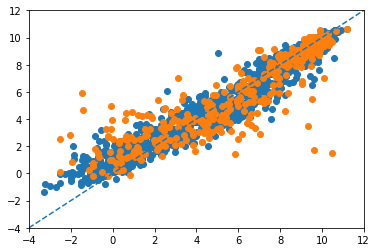

In [114]:
plt.scatter(y_train, model.predict(x_train), label='Train')
plt.scatter(y_test, y_test_pred, label='Test')
plt.xlim(-4,12)
plt.ylim(-4,12)
xx = range(-4,13)
yy =xx
plt.plot(xx, yy, '--')
plt.show()

In [115]:
test_data['pred']=y_test_pred
train_data['pred']=model.predict(x_train)
test_data.to_csv('test_data_pred_mf_5.csv', index=False)
train_data.to_csv('train_data_pred_mf_5.csv', index=False)

In [116]:
O3=test_data[test_data['oxidant']=='O3']

In [117]:
r2_score(O3['logK'], O3['pred']), np.sqrt(mean_squared_error(O3['logK'], O3['pred']))

(0.45508595346799763, 2.0905766477312553)

In [118]:
ClO2=test_data[test_data['oxidant']=='ClO2']
r2_score(ClO2['logK'], ClO2['pred']), np.sqrt(mean_squared_error(ClO2['logK'], ClO2['pred']))

(0.6512696907228606, 1.4649928213127361)

In [119]:
HClO=test_data[test_data['oxidant']=='HClO']
r2_score(HClO['logK'], HClO['pred']), np.sqrt(mean_squared_error(HClO['logK'], HClO['pred']))

(0.4672411443714396, 2.0328888805944096)

In [120]:
SO4=test_data[test_data['oxidant']=='SO4']
r2_score(SO4['logK'], SO4['pred']), np.sqrt(mean_squared_error(SO4['logK'], SO4['pred']))

(0.624881077995839, 0.7346013704294941)

In [121]:
OH=test_data[test_data['oxidant']=='OH']
r2_score(OH['logK'], OH['pred']), np.sqrt(mean_squared_error(OH['logK'], OH['pred']))

(0.46943771812535795, 0.367475874353347)

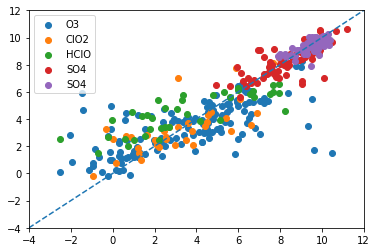

In [87]:
plt.scatter(O3['logK'], O3['pred'], label='O3')
plt.scatter(ClO2['logK'], ClO2['pred'], label='ClO2')
plt.scatter(HClO['logK'], HClO['pred'], label='HClO')
plt.scatter(SO4['logK'], SO4['pred'], label='SO4')
plt.scatter(OH['logK'], OH['pred'], label='SO4')
plt.xlim(-4,12)
plt.ylim(-4,12)
xx = range(-4,13)
yy =xx
plt.plot(xx, yy, '--')
plt.legend()
plt.show()

In [54]:
explainer = shap.TreeExplainer(model, data =x_train)
shap_value_train = explainer.shap_values(x_train, check_additivity=False)

#shap_value_train = explainer.shap_values(x_test)


 98%|===================| 2233/2288 [00:41<00:01]        

In [55]:
x_train_pd

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,pH,T,oxidant
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,25.0,4.345049
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,25.0,4.345049
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,25.0,4.345049
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,25.0,4.345049
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.31,25.0,4.345049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,25.0,9.435457
2284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,25.0,9.435457
2285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,25.0,9.435457
2286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,25.0,9.435457


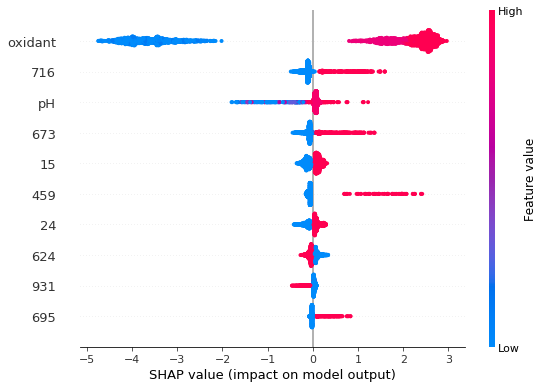

In [56]:
shap.summary_plot(shap_value_train, x_train_pd,max_display=10, show=False)
#plt.xlabel('SHAP value')
#plt.xticks(fontsize=22)
#plt.yticks(fontsize=22)
plt.tight_layout()
plt.savefig('xgb_train_shap_20.png', dpi =400)

In [57]:
train_data=pd.read_excel('all/train_data_5.xlsx')
test_data=pd.read_excel('all/test_data_5.xlsx')
SO4 = pd.concat([train_data,test_data], ignore_index=True)
SO4.head()

,chemical compound,new_smile,pH,logK,T,oxidant,fp
0,3-methoxyphenolate,COc1cccc([O-])c1,7.00,7.690196,25.0,ClO2,[0. 0. 0. ... 0. 0. 0.]
1,4-Styrenesulfonic Acid,C=Cc1ccc(S(=O)(=O)O)cc1,7.00,-1.886057,25.0,ClO2,[0. 0. 0. ... 0. 0. 0.]
2,2-carboxylatophenol,O=C([O-])c1ccccc1O,7.00,5.739687,25.0,ClO2,[0. 0. 0. ... 0. 0. 0.]
3,"N,N-dimethyl-4-Cl-benzylamine",CN(C)Cc1ccc(Cl)cc1,7.00,4.301030,25.0,ClO2,[0. 0. 0. ... 0. 0. 0.]
4,Lomefloxacin,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c21,6.31,0.146128,25.0,ClO2,[0. 0. 0. ... 0. 0. 0.]


In [58]:
SO4.drop_duplicates(subset=['new_smile'], keep='first', inplace=True)
SO4.reset_index(drop=True, inplace=True)
SO4['fp']=SO4['new_smile'].apply(fp)
X_data = np.array(list(SO4['fp']))

In [59]:
import os
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
from rdkit.Chem import Draw
for j in range(X_data.shape[1]):
    for i in range(X_data.shape[0]):
        if X_data[i][j]==1:
            mol = Chem.MolFromSmiles(SO4['new_smile'][i])
            bi = {}
            fp_env = AllChem.GetMorganFingerprintAsBitVect(mol, 1, 1022, bitInfo=bi)
            y=Draw.DrawMorganBit(mol, j, bitInfo= bi)
            f =open('{}.txt'.format(j), 'w+' )
            print(y, file =f)
            f.close()
            filename = '{}.txt'.format(j)
            portion = os.path.splitext(filename)
            newname = portion[0] + '.svg'
            os.rename(filename, newname)
            drawing = svg2rlg('{}.svg'.format(j))
            renderPM.drawToFile(drawing, 'five_atom/position_{}_compound_{}.png'.format(j, i), fmt="PNG")
            os.remove('{}.svg'.format(j))

In [62]:
from rdkit.Chem import Draw
for i in range(len(SO4)):
    m = Chem.MolFromSmiles(SO4['new_smile'][i])
    Draw.MolToFile(m, f'five_com/comp_{i}.png',size=(224, 224), fitImage=True)